# **_Como describimos_** la actividad de una neurona?

Datos sacados de [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x)


# Primero que nada
Alguien acá nunca usó Google Colab/Jupyter Notebooks?

# Configuración



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Configuración de figuras
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Funciones de graficado

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [4]:
#@title Devolución de datos
#@markdown Esta celda descarga la base de datos de ejemplo que utilizaremos en este tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Error descargando datos')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

---

# Sección 1: Explorando el conjunto de datos de Steinmetz

En este tutorial exploraremos la estructura de un conjunto de datos de neurociencia.

Consideraremos un subconjunto de datos del estudio de [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x). En este estudio, se implantaron sondas de neuropixeles en cerebros de ratones. Los potenciales eléctricos se midieron con cientos de electrodos a lo largo de cada sonda. Las medidas de cada electrodo capturaron las variaciones locales en el campo eléctrico debido a las neuronas cercanas. Se utilizó un algoritmo de clasificación de picos para inferir tiempos de picos y picos de grupos según un origen común: un solo grupo de picos ordenados se atribuye causalmente a una sola neurona.

En particular, **una sola sesión de grabación de los tiempos de disparos y las asignaciones de neuronas** se cargaron y asignaron a `spike_times` en la anterior configuración.

Por lo general, un conjunto de datos viene con cierta información acerca de su estructura. Sin embargo, esta información puede estar incompleta. También podrías aplicar algunas transformaciones o preprocesamiento para crear una "representación funcional" (una representación más útil) de los datos de interés.

Veamos cómo se ven nuestros datos...

## Sección 1.1: Toda nuestra data está en `spike_times`. Analicémosla


¿Qué tipo de variable es la que tenemos en Python?

In [5]:
type(spike_times)

numpy.ndarray

Forma (dimensiones) de spike_times

In [6]:
spike_times.shape

(734,)

Hay 734 entradas en una dimensión, y no hay otras dimensiones. ¿Cuál es el tipo de la primera entrada en Python, y cuál es *su* forma?

In [7]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


¡También es un array NumPy con una forma 1D! ¿Por qué no apareció como una segunda dimensión en la forma de `spike_times`? Es decir, ¿por qué no `spike_times.shape == (734, 826)`?

Para investigar, veamos otra entrada.

In [8]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


Cada elemento es un NumPy array de float32

In [9]:
i_neurons = [0, 321]
i_print = slice(0, 5) #Imprimimos los 1ros 5 elementos de c/u

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Toma en cuenta que esta vez revisamos el NumPy `dtype` en lugar del tipo de la variable Python. Estos dos arrays contienen números de punto flotantes ("floats") con 32 bits de precisión.

El cuadro básico se va formando:
- `spike_times` es 1D, sus entradas son arrays NumPy, y su longitud es el número de neuronas (734): al indexarlo, seleccionamos un subconjunto de neuronas.
- Un array en `spike_times` es también 1D y corresponde a una sola neurona; sus entradas son números de punto flotantes, y su longitud es el número de picos atribuidos a esa neurona. Al indexarse, seleccionamos un subconjunto de tiempos pico para esa neurona.

Visualmente, puedes pensar en la estructura de datos como lo siguiente:

```
| . . . . . |
| . . . . . . . . |
| . . . |
| . . . . . . . |
```

Antes de continuar, vamos a calcular y guardar el número de neuronas en el conjunto de datos y el número de picos por neurona:

In [10]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Número de neuronas: {n_neurons}")
print(f"Número de disparos para las 1ras cinco neuronas: {total_spikes_per_neuron[:5]}")

Número de neuronas: 734
Número de disparos para las 1ras cinco neuronas: [826, 2818, 3953, 646, 1115]


## Seccion 1.2: Como es la distribución de disparos entre neuronas?


¿Son la mayoría de las neuronas "ruidosas" o "silenciosas", en comparación con el promedio?

Puedes graficar un histograma con la función matplotlib `plt.hist`. Si sólo necesitas calcularlo,en su lugar puedes usar la función numpy `np.histogram`.

68.0% de las neuronas disparan menos que la media


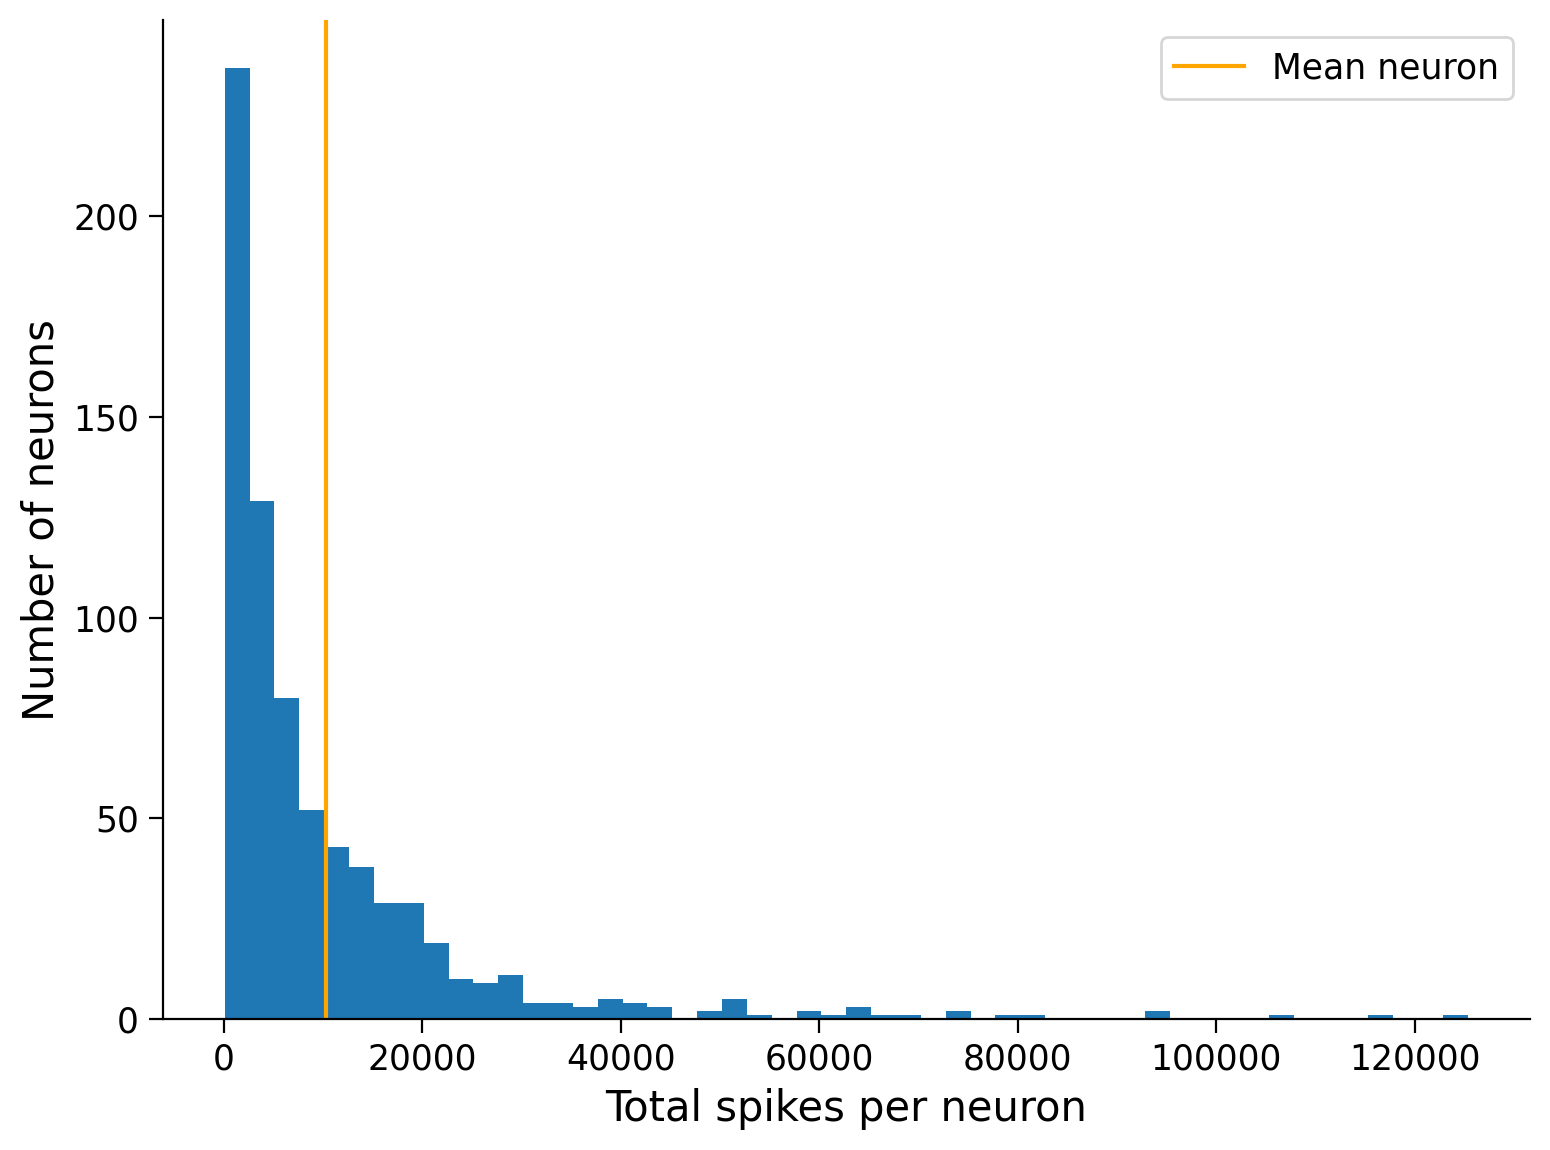

In [11]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()

plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();


print(f"{frac_below_mean:2.1%} de las neuronas disparan menos que la media")

---

# Sección 2: Visualizando _**trenes de disparo**_

## Sección 2.1: Obtener un subconjunto de los datos

Ahora visualizaremos trenes de potenciales de acción. Debido a que las grabaciones son largas, primero definiremos un intervalo de tiempo corto y restringiremos la visualización solo a los picos en este intervalo. Definimos una función de ayuda, `restrict_spike_times`, para hacer esto por ti. Si llamas a `help()` en la función, te describirá un poco sobre sí mismo:

In [12]:
def restrict_spike_times(spike_times, interval):
  """Restringe un tren de disparos a un intervalo de tiempo dado.

  Args:
    spike_times (secuencia of np.ndarray)

    interval (tupla): Min, max valores de tiempo; mantiene disparos en min <= t < max.

  Retorna:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [13]:
t_interval = (5, 15)  # las unidades son segundos después del inicio de la grabación
interval_spike_times = restrict_spike_times(spike_times, t_interval)

¿Es este un intervalo representativo? ¿Qué fracción del total de picos cae en este intervalo?

In [14]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} de los potenciales de acción totales están en el intervalo")

0.33% de los potenciales de acción totales están en el intervalo


¿Cómo se compara esto con la relación entre la duración del intervalo y la duración del experimento? (¿Qué fracción del tiempo total está en este intervalo?)

Podemos aproximar la duración del experimento tomando el tiempo de pico mínimo y máximo en todo el conjunto de datos. Para hacer eso, "concatenamos" todas las neuronas en una matriz y luego usamos `np.ptp` ("pico a pico") para obtener la diferencia entre el valor máximo y mínimo:


In [15]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} del tiempo total está en el intervalo")

0.37% del tiempo total está en el intervalo


Estos dos valores, la fracción de picos totales y la fracción de tiempo total, son similares. Esto sugiere que la tasa promedio de picos de la población neuronal no es muy diferente en este intervalo en comparación con el registro completo.

**¿Cual sería otra manera de ver como varía la tasa promedio de disparos?** (capaz más formalmente)

## Sección 2.2: Graficado de trenes de potenciales de acción (rasterplots)

Ahora que tenemos un subconjunto representativo, estamos listos para graficar los picos utilizando la función `plt.eventplot` de matplotlib. Veamos primero una sola neurona:


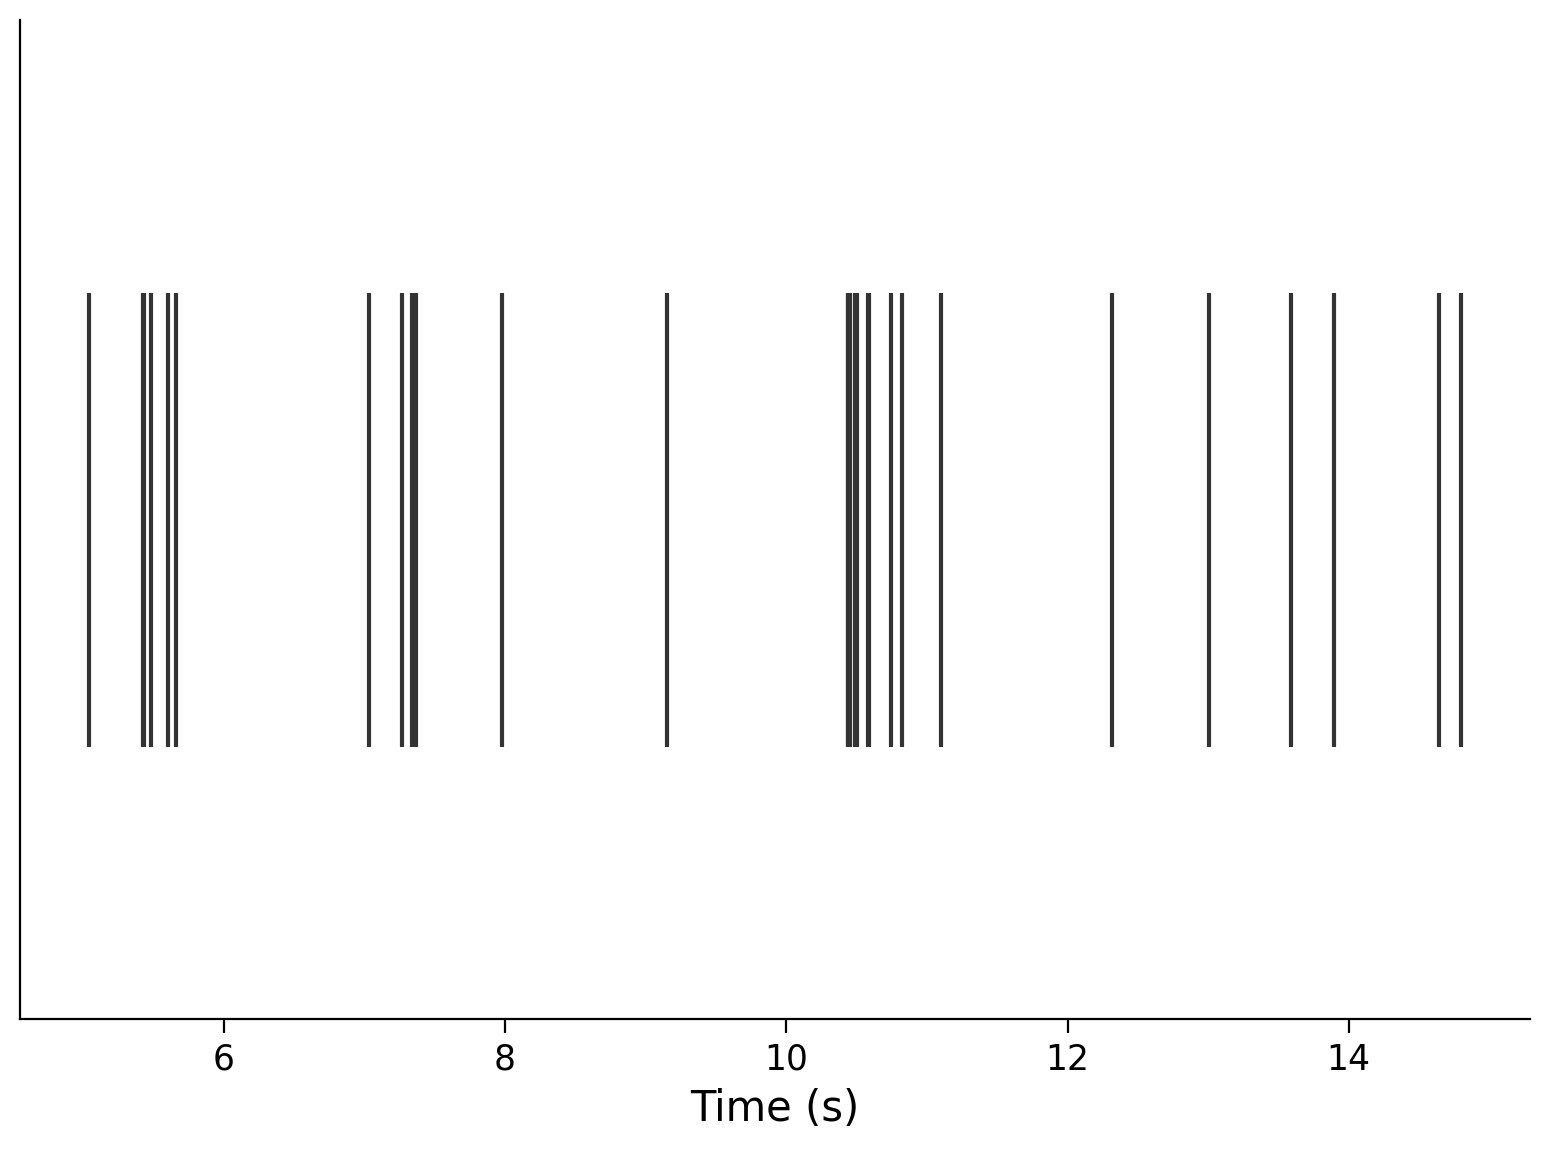

In [16]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

También podemos graficar múltiples neuronas. Aquí tenemos tres:

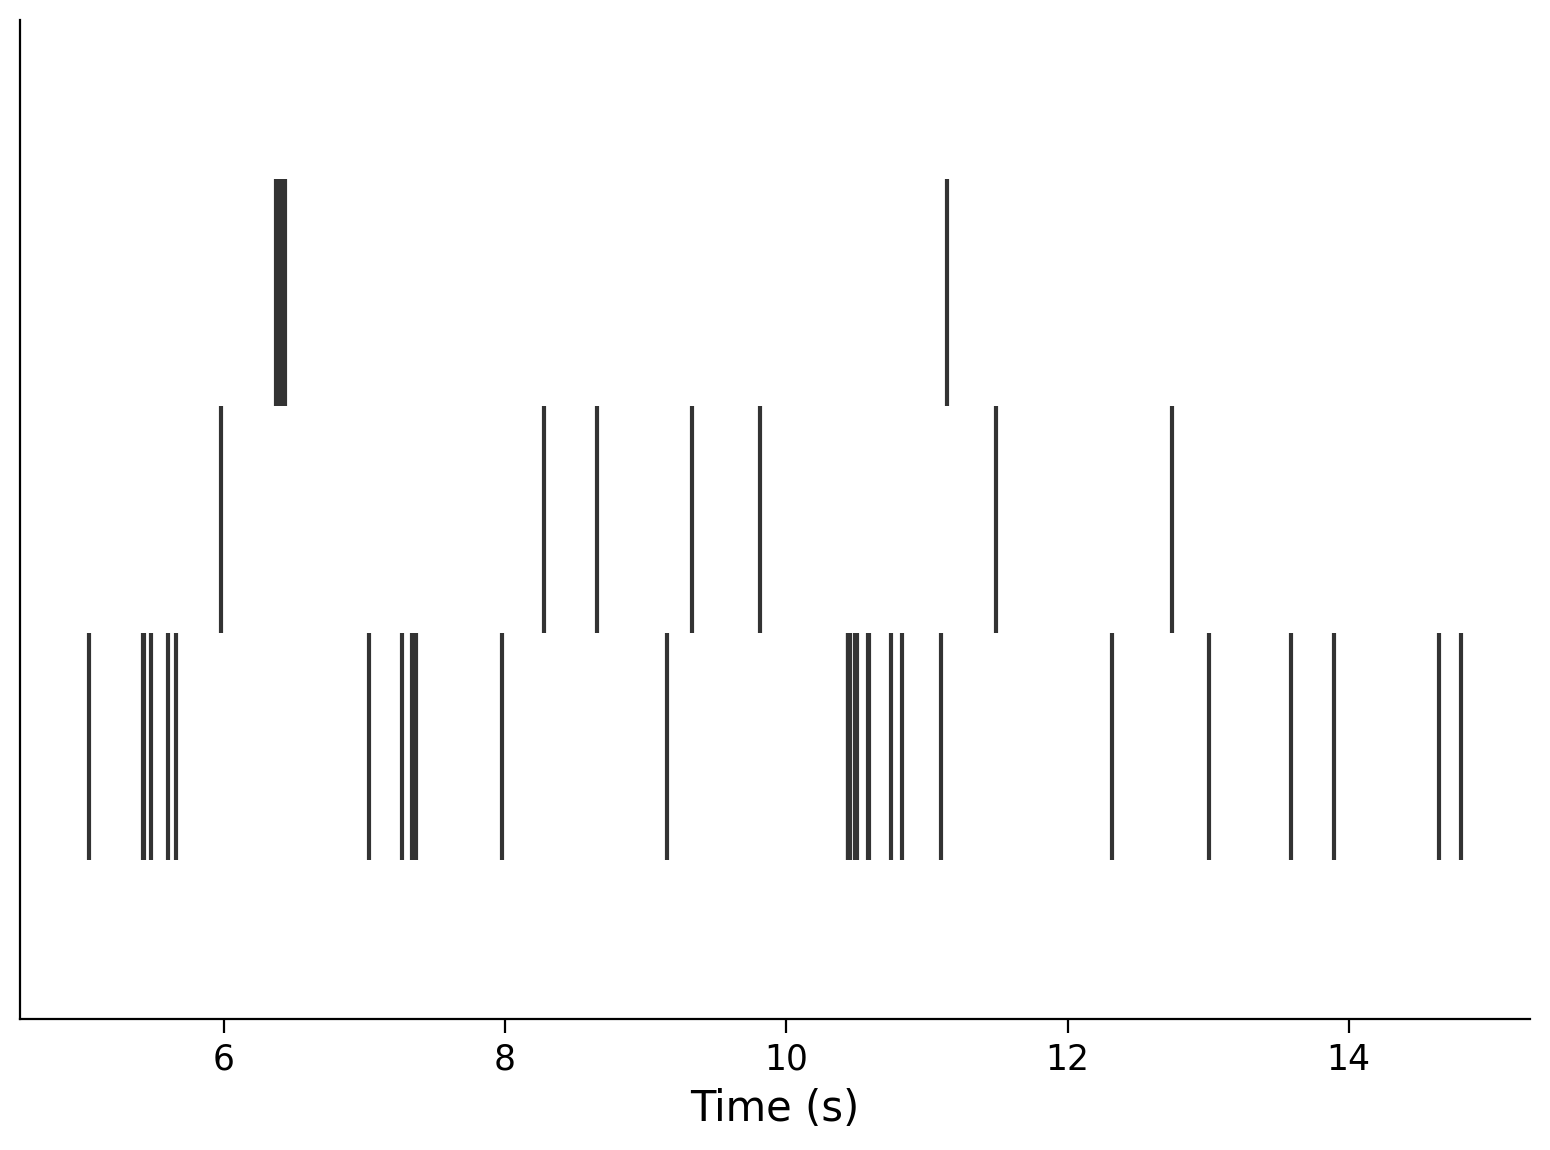

In [17]:
neuron_idx = [1, 11, 51] #Neuronas que queremos graficar
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

Esto crea un gráfico "ráster", donde los picos de cada neurona aparecen en una fila diferente.

Graficar una gran cantidad de neuronas puede darte una idea de las características de la población. Mostremos cada quinta neurona que se registró:


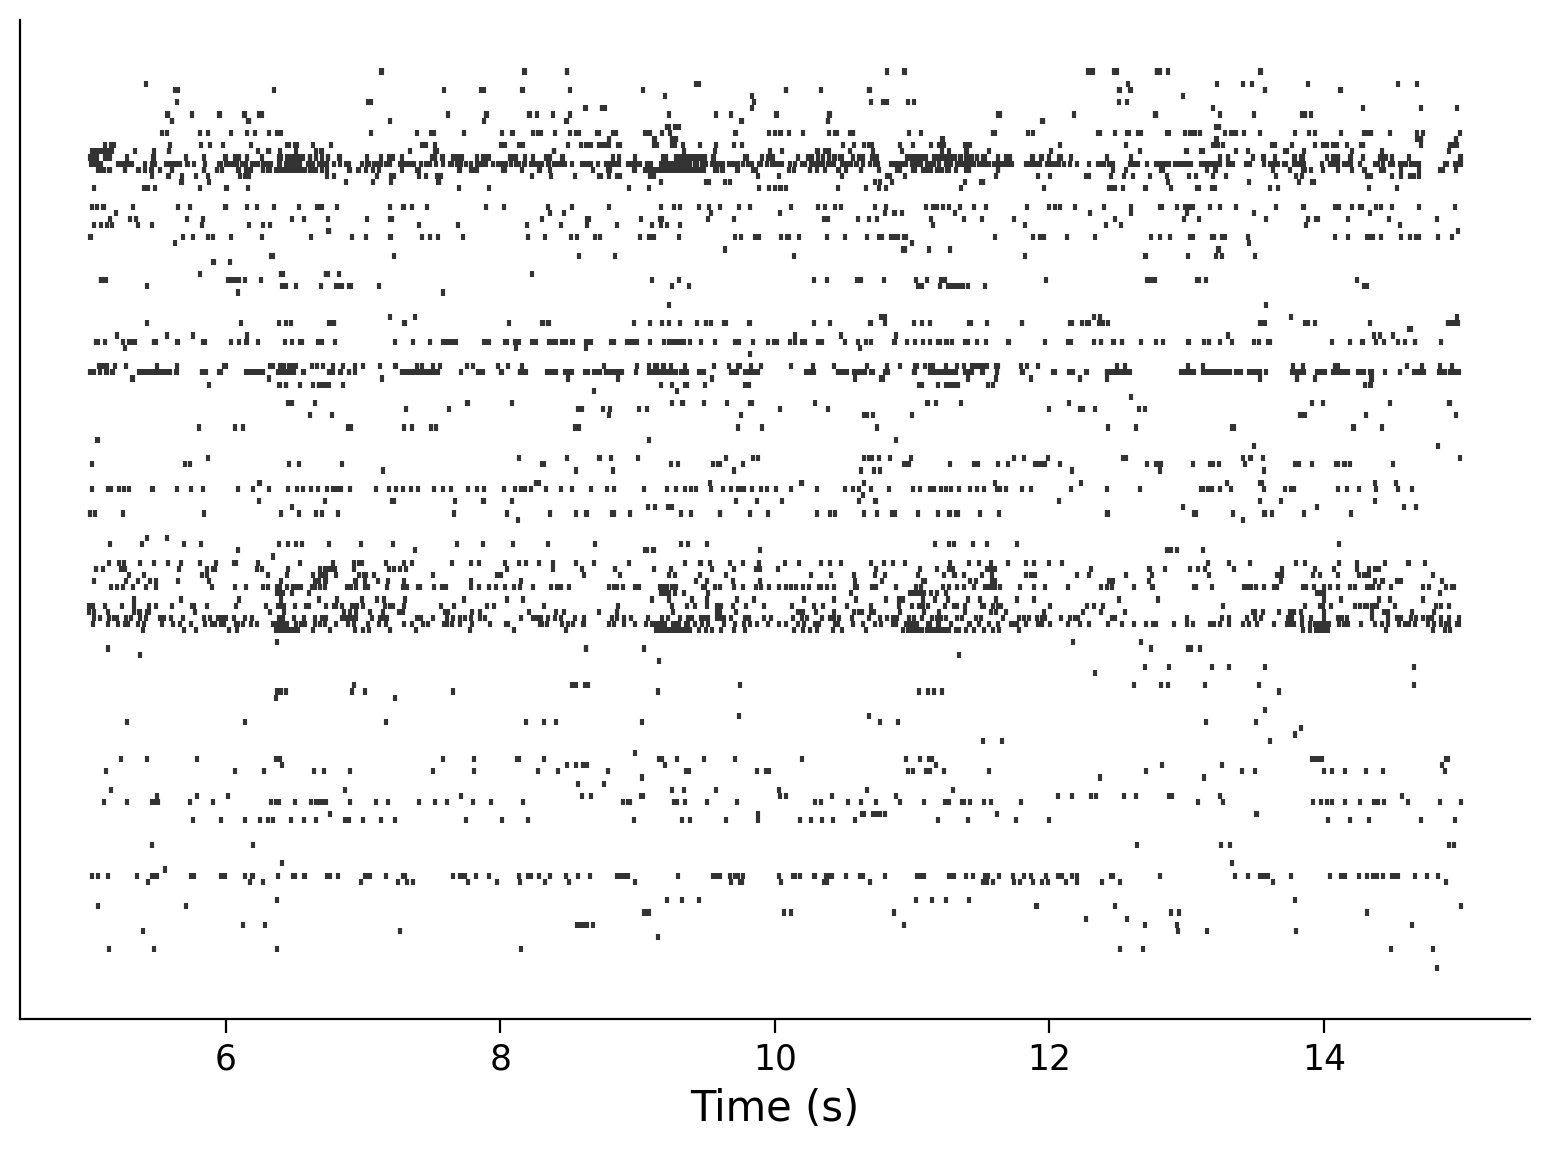

In [18]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

---

# Sección 3: Intervalos entre picos (Inter Spike Intervals) y sus distribuciones

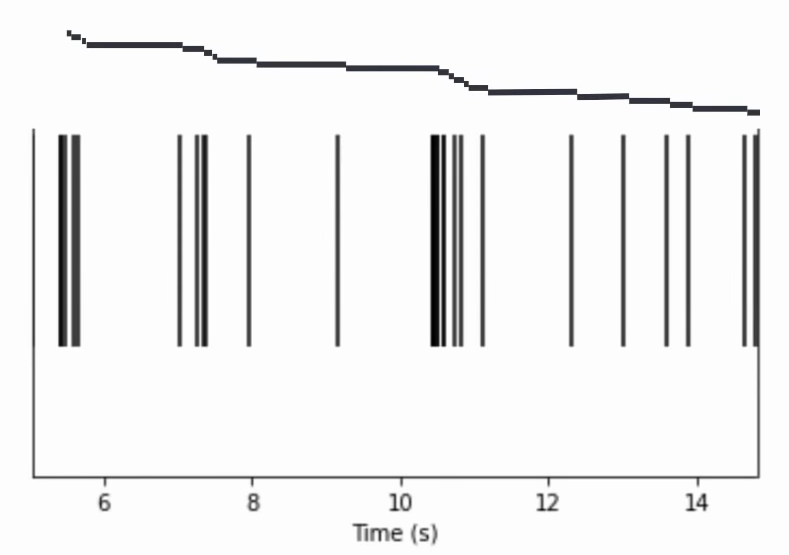

### Como se ven los ISIs?
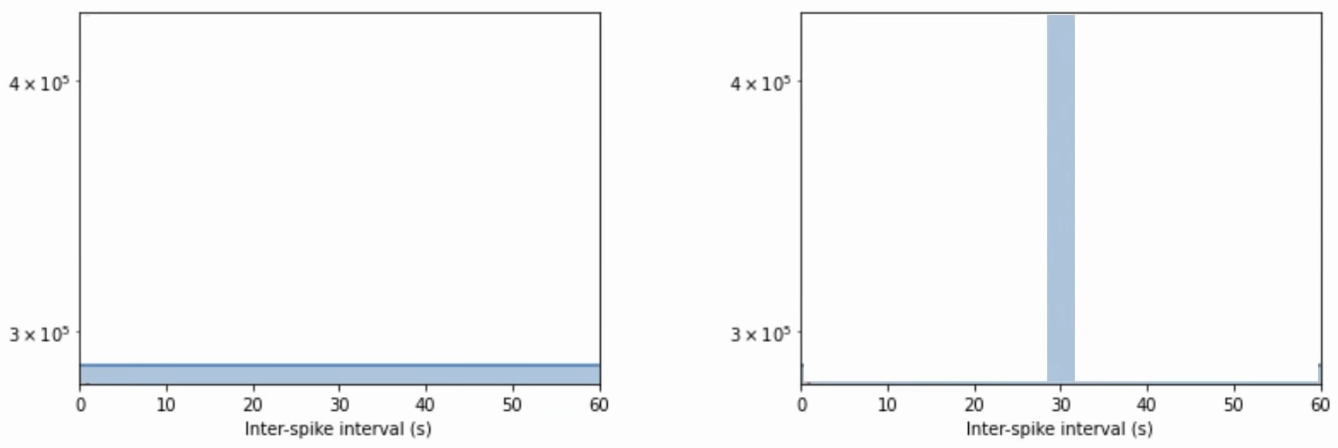

Sabemos que existen limitaciones físicas en los picos neuronales.
* Los picos cuestan energía
* La maquinaria celular de la neurona solo puede obtener a un ritmo finito.

Por lo tanto, las neuronas deben tener un **período refractario**: solo pueden activarse tan rápido como sus procesos metabólicos lo permitan, y hay un retraso mínimo entre picos consecutivos de la misma neurona.

Podemos preguntar
* ¿cuánto tiempo espera una neurona para volver a dispararse?
* ¿cuánto es lo máximo que esperará una neurona?
* ¿Podemos transformar los tiempos pico en algo más, para abordar preguntas como estas de manera más directa?

### Grafiquemos la distribución de ISIs para una sola neurona

Tres pasos:

1. Extrae los tiempos de disparo para una de las neuronas.
2. Calcula los ISIs (la cantidad de tiempo entre picos o, de manera equivalente, la diferencia entre tiempos de picos adyacentes)
3. Grafica un historiograma con el array de ISIs individuales

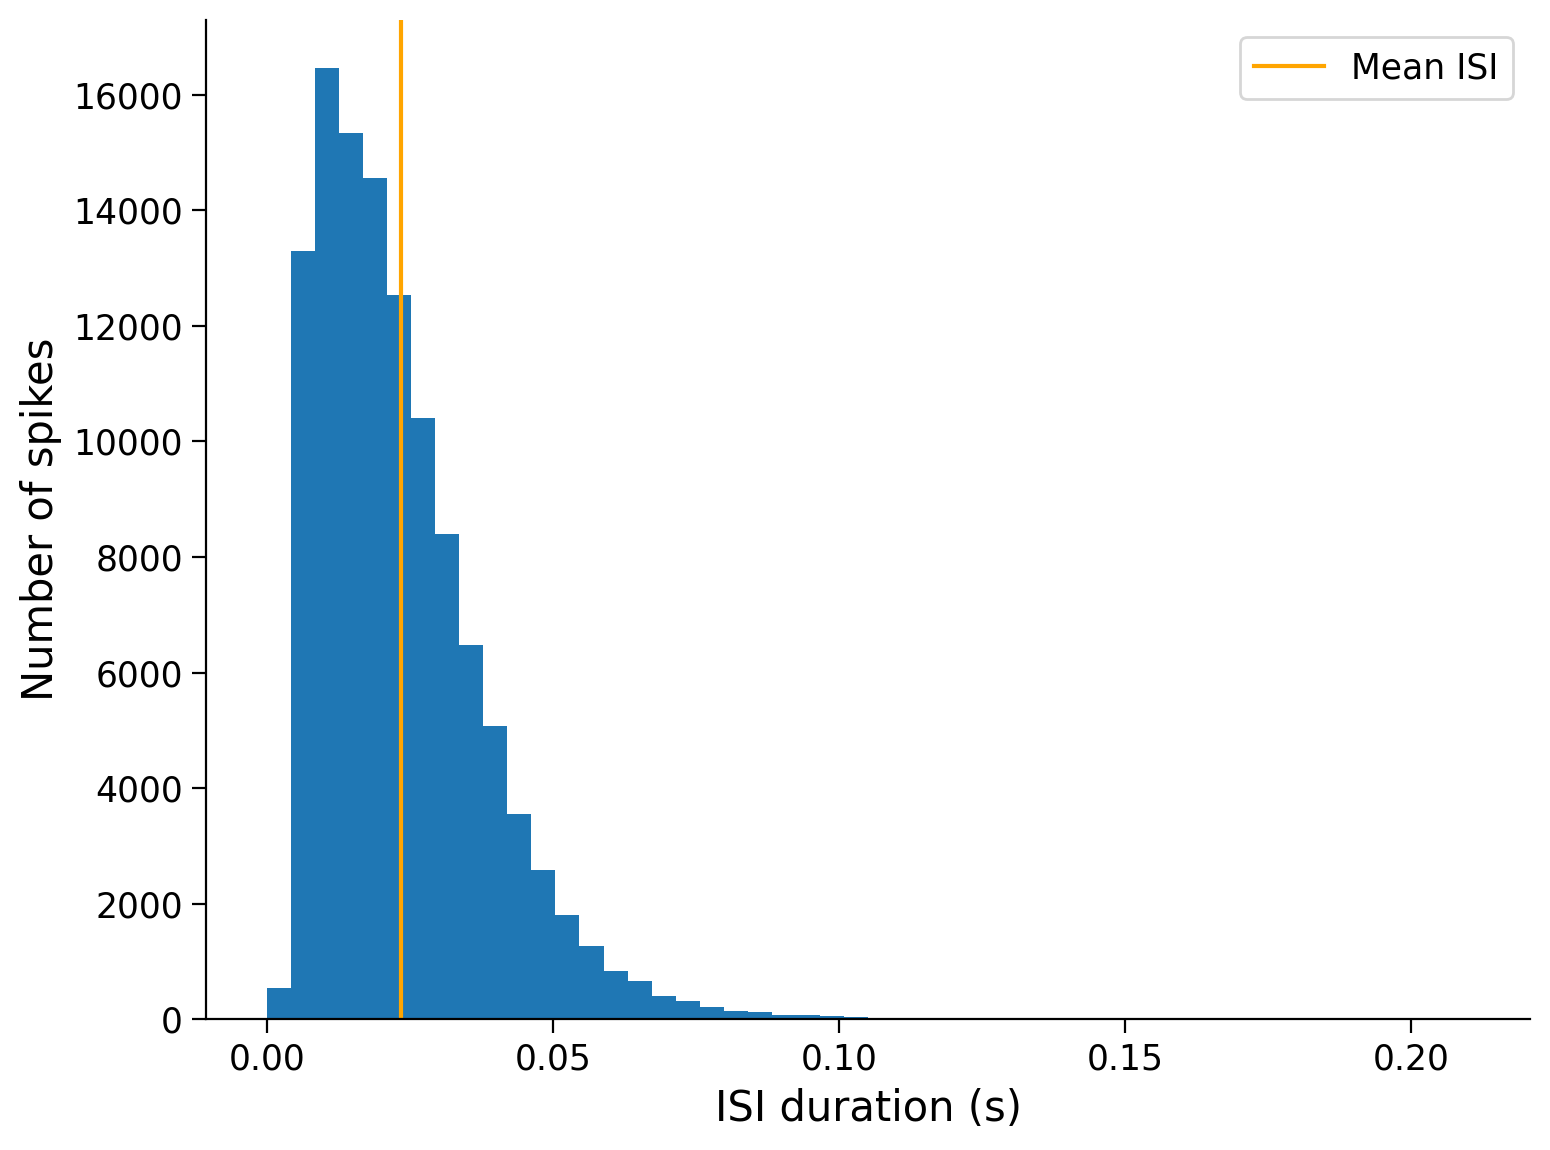

In [19]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Calcular un vector de ISIs para una sola neurona dados los tiempos de los picos.

  Args:
    spike_times (lista de arrays 1D): Conjunto de datos de tiempo de pico, con
    la primera dimensión correspondiente a diferentes neuronas.
    neuron_idx (int): Índice de la unidad para calcular los ISIs.

  Returns:
    isis (1D array): Duración del tiempo entre cada pico de una neurona.
  """
  #############################################################################

  # Extraiga los tiempos de pico para la neurona especificada
  single_neuron_spikes = spike_times[neuron_idx]

  # Calcular los IEPs para este conjunto de picos
  # Pista: la función np.diff calcula diferencias discretas a lo largo de un array
  isis = np.diff(single_neuron_spikes)

  return isis

# Calcular IEPs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualizar IEPs
plot_isis(single_neuron_isis)

---

En general, predominan los ISIs más cortos, con recuentos que disminuyen rápidamente (y suavemente, más o menos) con el ISIs creciente. Sin embargo, los conteos también disminuyen rápidamente a cero con un ISI _decreciente_ por debajo del máximo de la distribución (8-11 ms).

### **Pregunta: _¿Por que faltan ISIs muy pequeños?_**


---

# Sección 4: ¿Cuál es la forma funcional de una distribución de ISIs?

### **a.k.a. ¿como lo describimos con una función?**

Los histogramas de ISI parecen seguir funciones continuas y monótonamente decrecientes por encima de sus máximos. La función es claramente no lineal. ¿Podría pertenecer a una sola familia de funciones?

Para motivar la idea de usar una función matemática para explicar fenómenos fisiológicos, definamos algunas formas de función diferentes que podríamos esperar que siga la relación: exponencial, inversa y lineal.


In [20]:
def exponential(xs, scale, rate, x0):
  """Una función exponencial parametrizada simple, aplicada por elementos.

  Args:
    xs (np.ndarray or float): Input(s) a la función.
    scale (float): Factor de escala lineal (vertical)
    rate (float): Crecimiento exponencial (positivo) o decaída (negativo).
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """Una función inversa parametrizada simple (`1/x`), aplicada por elementos.

  Args:
    xs (np.ndarray or float): Input(s) a la función.
    scale (float): Factor de escala lineal.
    x0 (float): Desplazamiento horizontal.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """Una función lineal simple, aplicada a los elementos.

  Args:
    xs (np.ndarray or float): Input(s) a la función.
    slope (float): Pendiente de la línea.
    y0 (float): y-intersección de la línea.

  """
  ys = slope * xs + y0
  return ys

### Demostración interactiva 4: Explorador de funciones del IEP

Aquí hay una demostración interactiva donde puedes modificar los parámetros de las funciones y ver qué tan bien los resultados corresponden con los datos. Ajuste los parámetros moviendo los controles deslizantes y vea qué tan cerca puede mover las líneas para seguir la curva descendente del histograma. Esto le dará una idea de lo que intenta hacer cuando *ajusta un modelo* a los datos.

Las celdas de la "demostración interactiva" tienen un código oculto que define una interfaz donde puedes jugar con los parámetros de alguna función usando controles deslizantes. No necesita preocuparse por cómo funciona el código, pero sí necesita **ejecutar la celda** para habilitar los controles deslizantes.

**_¿Qué tipo de función (exponencial/inversa/lineal) puede hacer que coincida mejor con los datos?__**

In [21]:
#@markdown Corre esta celda para habiliar la demo interactiva
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

##### Mejores valores:

exp_scale = 1000
exp_rate = -64
exp_x0 = 0.07
inv_scale = 80
inv_x0 = 0.02
lin_slope -310000
lin_y0 = 18000

### Preguntas
¿Cual de los modelos se ajusta mejor?

¿Donde fallan estos modelos?

¿Que característica fisiológica importante no está modelando?

¿Que distribución podría ser más apropiada?

# Volvamos a la presentación!